# Notebook 3:  Flight of Passage EDA & Modeling

Capstone Project, Nadia W. Morgen

## Data & Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pickle

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  
plt.style.use('fivethirtyeight')

In [2]:
flight_posted = pd.read_csv('data/flight_posted.csv')
flight_actl = pd.read_csv('data/flight_actl.csv')

In [3]:
flight_posted.dtypes

date         object
datetime     object
SACTMIN     float64
SPOSTMIN    float64
weekday       int64
day_name     object
dtype: object

I have to reconvert the fields into my desired datatypes and reestablish date as the index.

In [4]:
flight_posted['date'] = pd.to_datetime(flight_posted['date'])
flight_posted['datetime'] = pd.to_datetime(flight_posted['datetime'])
flight_posted['day_name'] = flight_posted.day_name.astype('string')
flight_posted['date2'] = flight_posted['date']

flight_actl['date'] = pd.to_datetime(flight_actl['date'])
flight_actl['datetime'] = pd.to_datetime(flight_actl['datetime'])


# Also creating two dataframes, one indexed on date, the other indexed on datetime
# This makes future computations much easier
flight_date = flight_posted.copy()
flight_date.set_index('date', inplace=True)


flight_dt = flight_posted.copy()
flight_dt.set_index('datetime', inplace = True)


# Breakup up data into precovid and covid-era
# precovid_daily includes wait times with daily means
precovid_daily = flight_posted.copy()
precovid_daily['date2'] = precovid_daily['date']

covid = flight_posted.copy()
covid['date2'] = covid['date']
covid = covid[covid['date'] > '2019-07-15']

# precovid includes all rows for each day during covid
# each day has roughly 1 row for every 7 min the ride was open
precovid = flight_posted.copy()
precovid = precovid[precovid['date'] < '2020-07-15']


flight_posted.set_index('date', inplace = True)
flight_actl.set_index('date', inplace = True)

In [5]:
flight_posted.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2
date,,,,,,
2017-05-26,2017-05-26 09:10:12,NaN,5.0,5,Friday,2017-05-26
2017-05-26,2017-05-26 09:17:09,NaN,60.0,5,Friday,2017-05-26
2017-05-26,2017-05-26 09:24:07,NaN,60.0,5,Friday,2017-05-26
2017-05-26,2017-05-26 09:30:10,NaN,60.0,5,Friday,2017-05-26
2017-05-26,2017-05-26 09:38:10,NaN,45.0,5,Friday,2017-05-26


# EDA - Na'vi River Journey

## Overview

The data are imperfect.  There are days when there are multiple values recorded and days where there are none.  We see more missing data in 2020.  A large chunk of that was due to park closures due to COVID.  However, this doesn't explain the gap between Jan, 2021 and July, 2021.

### Wait Times Since the Ride Opened

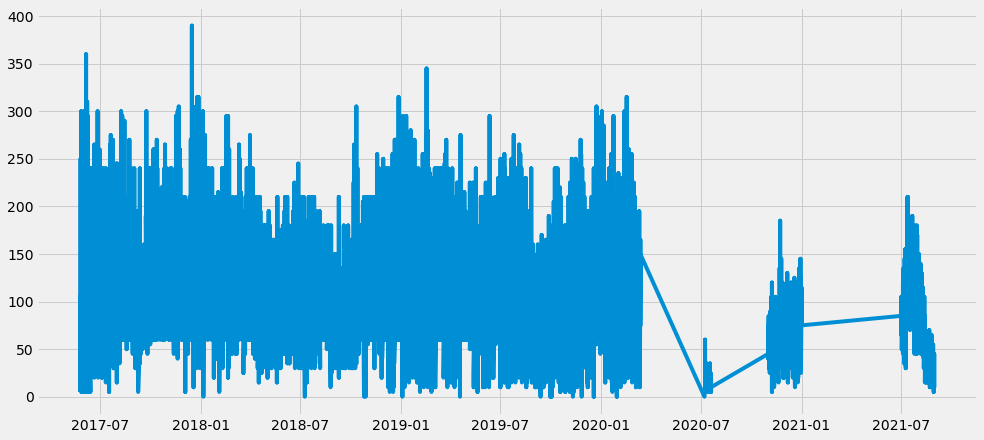

In [6]:
# Plot all wait times
plt.figure(figsize = (15, 7))
plt.plot(flight_posted['SPOSTMIN']);

In [7]:
print(f"Minimum Wait: {flight_posted['SPOSTMIN'].min()}")
print(f"Maximum Wait: {flight_posted['SPOSTMIN'].max()}")

Minimum Wait: 0.0
Maximum Wait: 390.0


There are obvious fluctuations in the data, but are they seaasonal?  December, 2017, 2018, and 2019 all saw wait times exceeding 300 minutes for this ride.  But there are multiple spikes near or exceeding 300 minutes.  Some appear to be around Presidents' Day week, spring breaks, and summer vacation.  But there are too many to tell from this plot.  It definitely warrants further analysis.

Because of missing data and the covid closure (March 15 - July 11, 2020), I'm separating the precovid data from the covid data.  Because covid began affecting tourism prior to Disney's official closure, "precovid" will be defined as prior to January 1, 2019.

In [8]:
# Limit data to precovid
precovid_daily = precovid_daily[precovid_daily.date2 < '2020-01-01']
precovid_daily.set_index('date', inplace=True)

# Group waiting times by date to get avg_daily_posted_wait
precovid_daily['avg_daily_wait'] = precovid_daily.groupby('date2')['SPOSTMIN'].mean()
precovid_daily = precovid_daily.drop_duplicates(subset='date2', keep='first')
precovid_daily.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2017-05-26,2017-05-26 09:10:12,NaN,5.0,5,Friday,2017-05-26,45.866667
2017-05-27,2017-05-27 07:17:06,NaN,60.0,6,Saturday,2017-05-27,196.302521
2017-05-28,2017-05-28 07:30:13,NaN,5.0,7,Sunday,2017-05-28,190.689655
2017-05-29,2017-05-29 07:10:11,NaN,25.0,1,Monday,2017-05-29,141.744186
2017-05-30,2017-05-30 07:52:05,NaN,5.0,2,Tuesday,2017-05-30,154.160305


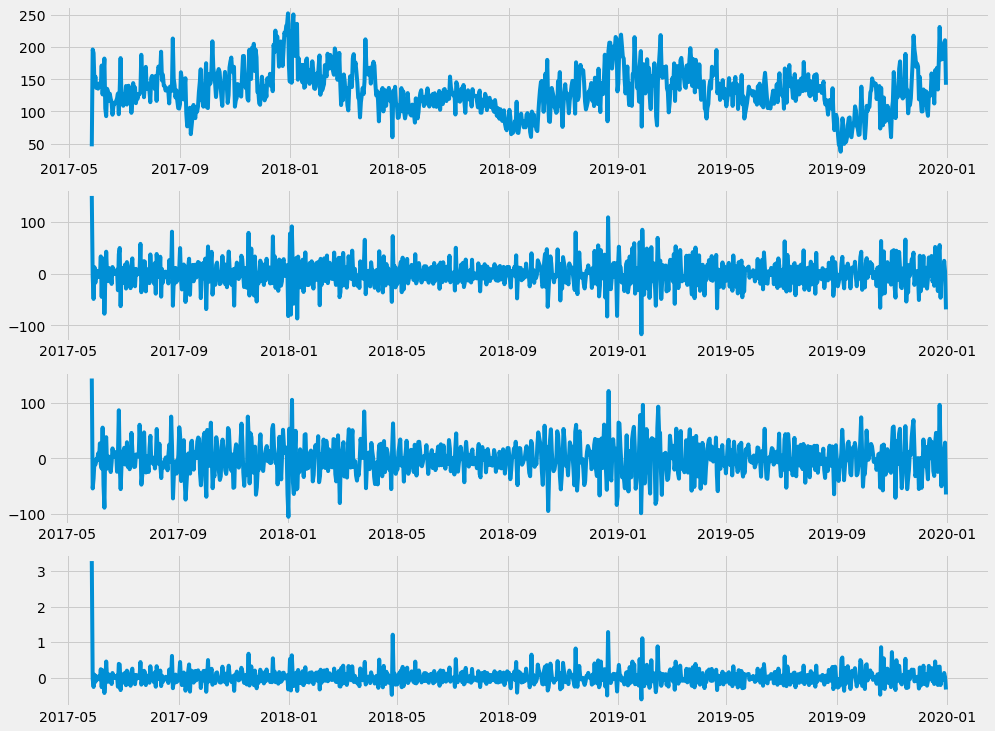

In [9]:
fig, axes = plt.subplots(nrows = 4, figsize = (15, 12))
axes[0].plot(precovid_daily['avg_daily_wait'])
axes[1].plot(precovid_daily['avg_daily_wait'].diff())
axes[2].plot(precovid_daily['avg_daily_wait'].diff(2))
axes[3].plot(precovid_daily['avg_daily_wait'].pct_change());

Top plot: Daily mean wait time
2nd plot: Daily mean wait time differenced once
3rd plot: Daily mean wait time differenced twice
4th plot: Percent change of daily mean wait time

There are some indications of seasonality.  Note that the ride opened on May 26, 2017, so the initial spike can be ignored.  But there are spikes in December, 2017, 2018, and 2019.  Covid likely explains the less prominent spike in Dec, 2019.  The parks were still open, but people from many countries (especially Asia) were unable to travel.

The 4th plot (percent difference) shows small spikes in mid-late April, 2018, November/December, 20118, and February and March, 2019.  The "spikes" are small; they describe an over 1% increase in wait times.  Even with a wait time of 300 minutes, this only adds 3 minutes to the wait.  This really isn't meaningful qualitatively.  If someone is willing to wait 300 minutes for a ride, they're willing to wait 303 minutes.

Ultimately, there is some evidence of seasonality that I will investigate further in the modeling section.

Given the lack of stationarity in the plots above, and given the nature of Disney's business, I need to explore the data for hourly "seasonality," weekly "seasonality," and possibly monthly "seasonality."

## Day of the Week Seasonality

I would expect longer wait times on weekends, when locals and especially annual passholders are most likely to visit the park.

In [10]:
precovid_daily['SPOSTMIN'].mean()

65.80168776371308

In [11]:
# Check for Seasonality Based on Day of the week
# Calculate average daily wait based on day of the week (all Mondays, etc.)

av_wait_by_day_of_week = precovid_daily.groupby('day_name')['avg_daily_wait'].mean()
av_wait_by_day_of_week

day_name
Friday       140.179995
Monday       136.121497
Saturday     143.349464
Sunday       131.454415
Thursday     132.286088
Tuesday      128.980914
Wednesday    122.117163
Name: avg_daily_wait, dtype: float64

Average daily wait time for Flight of Passage was 1 hour and 43 minutes before COVID.  Based on the summary above, Wednesdays have the shortest average wait and Saturdays have the longest.  However, when ride waits exceed 2 hours, do 12 minutes make a substantial, qualitative difference to riders?  Or are they more likely to opt out or buy an individual Lightning Lane pass to skip the line?

My personal advice: If you want to ride this ride, purchase Genie+.  

## Hourly Seasonality

Given the difference between the average daily wait time (103 min) and the average wait times per day listed above, I'm guessing that there are better and worse times of the day to ride this ride.  

First, I'll examine data for a Wednesday (when the average wait was shortest) and a Saturday (when average wait was longest) and look for hourly trends.

In [12]:
# Step 1: Filter data for one day
# This was the Wednesday after Thanksgiving, 2018

flight_Wed_Dec_05 = precovid[precovid['date'] == '2018-12-5']
flight_Wed_Dec_05.set_index('datetime', inplace = True)

In [13]:
print(f"Minimum wait: {flight_Wed_Dec_05['SPOSTMIN'].min()}")
print(f"Maximum wait: {flight_Wed_Dec_05['SPOSTMIN'].max()}")

Minimum wait: 60.0
Maximum wait: 170.0


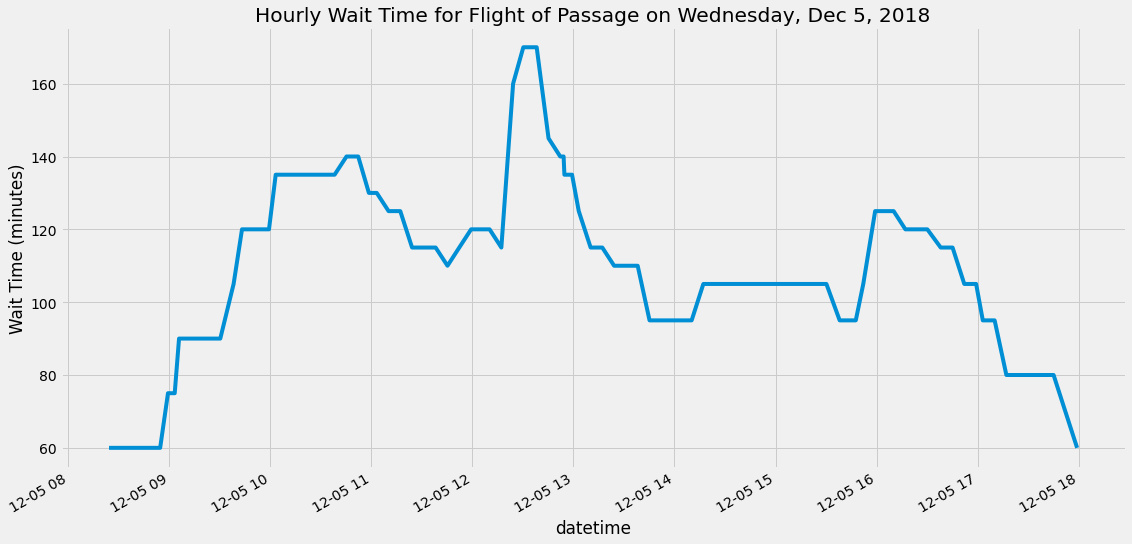

In [14]:
# Step 2: Plot hourly data for Wednesday, Dec 5, 2018

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Flight of Passage on Wednesday, Dec 5, 2018")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')


flight_Wed_Dec_05['SPOSTMIN'].plot();

If guests don't want to purchase an individual Lightning Lane pass for this ride, they should arrive at the park early and ride it first.  The wait time in the evening goes down also, but staff close the ride entrance before the park closes, so that riders are off the ride by closing time.  Remember, this is a lower-volume Wednesday.

The hourly plots for Wednesday and Saturday (top plot below) differ substantially.  The Saturday plot shows thw wait time spiking shortly after the ride opens and remaining long until shortly before the ride closes.  The Wednesday plot has several ebbs and flows, including spikes at 10am, 12:30pm, and about 4pm.  Is this typical for Saturdays?  Or is this just the pattern on this particular Saturday?

In [15]:
# Step 3: Create data for Saturday, Dec 8, 2018

flight_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
flight_Sat_Dec_08.set_index('datetime', inplace = True)

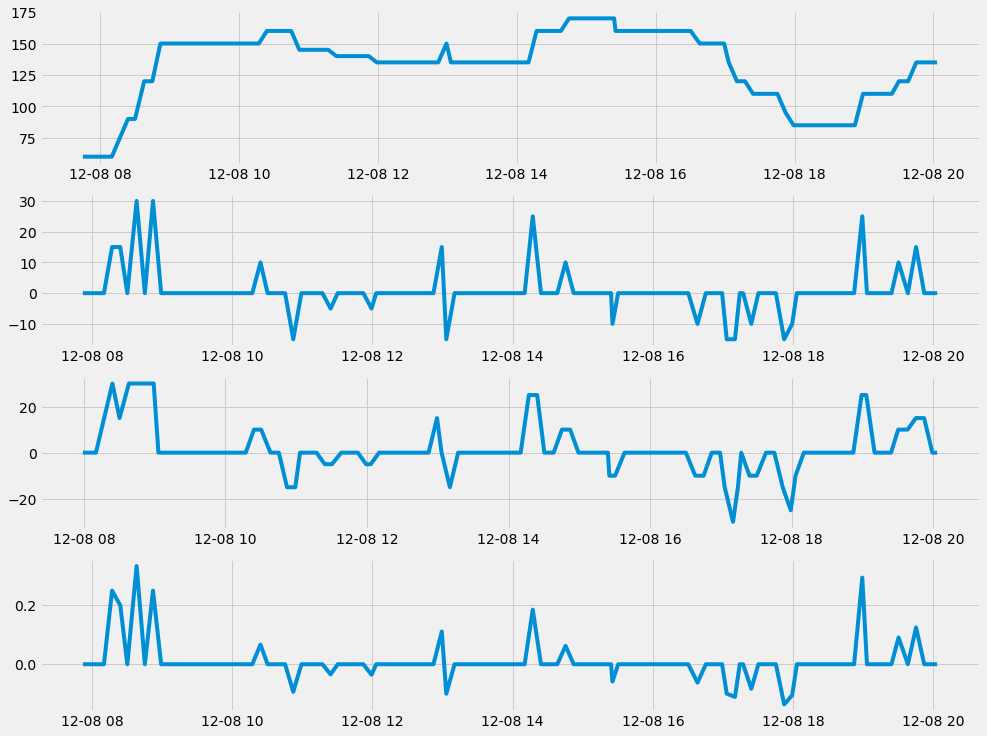

In [16]:
# Step 4: Plot hourly data for Saturday, Dec 8, 2018

# Plot unchanged, differenced, and percent change
fig, axes = plt.subplots(nrows = 4, figsize = (15, 12))
axes[0].plot(flight_Sat_Dec_08['SPOSTMIN'])
axes[1].plot(flight_Sat_Dec_08['SPOSTMIN'].diff())
axes[2].plot(flight_Sat_Dec_08['SPOSTMIN'].diff(2))
axes[3].plot(flight_Sat_Dec_08['SPOSTMIN'].pct_change());

Plots 2 and 3 (the two middle plots) show differenced data.  Plot 2 is differenced once and plot 3 is differenced twice.  They look very similar.  Differencing twice did not help achieve stationarity.

The percent change plot (the last plot) looks very similar to the differenced plot, especially where diff = 1. In practical terms, the percent change plot illustrates the changes a little more clearly than the first plot does.  In other words, wait times jump up and down first thing in the morning, increase almost 20% around 2:30pm, and increase almost 30% around 7pm.

In [17]:
print(f"Minimum wait: {flight_Sat_Dec_08['SPOSTMIN'].min()}")
print(f"Maximum wait: {flight_Sat_Dec_08['SPOSTMIN'].max()}")

Minimum wait: 60.0
Maximum wait: 170.0


Given the minimum wait of 60 minutes for this ride, I highly recommend purchasing Genie+ if you want to experience the feeling of flying on a Banshee.  If being jerked around in front of moving images that make you feel like you're flying wildly does not appeal to you, skip this ride.

In [18]:
# Step 5: Create df for Saturdays only
flight_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
saturdays = precovid.copy()
saturdays = saturdays[saturdays['day_name'] == 'Saturday']
saturdays = saturdays.groupby('date')

In [19]:
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2
75,2017-05-27,2017-05-27 07:17:06,NaN,60.0,6,Saturday,2017-05-27
76,2017-05-27,2017-05-27 07:24:09,NaN,90.0,6,Saturday,2017-05-27
77,2017-05-27,2017-05-27 07:30:11,NaN,90.0,6,Saturday,2017-05-27
78,2017-05-27,2017-05-27 07:38:05,NaN,90.0,6,Saturday,2017-05-27
79,2017-05-27,2017-05-27 07:52:05,NaN,120.0,6,Saturday,2017-05-27
...,...,...,...,...,...,...,...
122698,2020-07-11,2020-07-11 08:02:10,NaN,5.0,6,Saturday,2020-07-11
122699,2020-07-11,2020-07-11 08:03:02,NaN,5.0,6,Saturday,2020-07-11
122700,2020-07-11,2020-07-11 08:10:03,NaN,10.0,6,Saturday,2020-07-11
122701,2020-07-11,2020-07-11 08:17:02,NaN,20.0,6,Saturday,2020-07-11


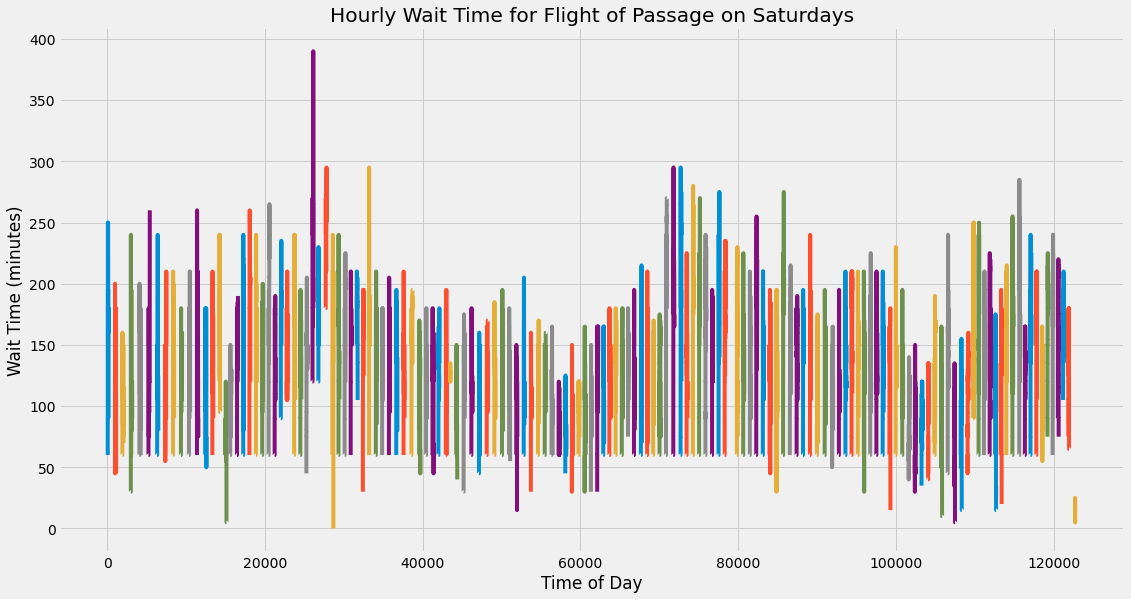

In [20]:
# Step 6: Plot hourly data for all Saturdays

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Flight of Passage on Saturdays")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

saturdays['SPOSTMIN'].plot();

There might be some hourly seasonality for Saturdays, but it's very difficult to tell in this plot.  I'll revisit this in the SARIMAX model.

## Weekly Seasonality

In [21]:
# copy dataframe
precovid_weekly = precovid_daily.copy()

# create day number
precovid_weekly['day_num'] = range(0, len(precovid_weekly))

# use day number to create and calculate week number
precovid_weekly['week_num'] = (precovid_weekly['day_num'] // 7)

# delete duplicates before indexing
precovid_weekly.drop_duplicates(subset='week_num', keep = 'first', inplace=True)

# copy dataframe before indexing for future use
precovid_weekly_2 = precovid_weekly.copy()

# set index to week number
precovid_weekly.set_index('week_num', inplace=True)

# groupby week
precovid_weekly['avg_weekly_wait'] = precovid_weekly.groupby('week_num')['avg_daily_wait'].mean()
precovid_weekly.shape

(136, 9)

In [22]:
# verify it worked
precovid_weekly.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,avg_weekly_wait
week_num,,,,,,,,,
0,2017-05-26 09:10:12,NaN,5.0,5,Friday,2017-05-26,45.866667,0,45.866667
1,2017-06-02 07:38:50,NaN,5.0,5,Friday,2017-06-02,135.429688,7,135.429688
2,2017-06-09 07:45:10,NaN,5.0,5,Friday,2017-06-09,182.210526,14,182.210526
3,2017-06-16 07:45:13,NaN,60.0,5,Friday,2017-06-16,119.741935,21,119.741935
4,2017-06-23 07:52:17,NaN,100.0,5,Friday,2017-06-23,119.969512,28,119.969512


In [23]:
# copy dataframe
covid_weekly = precovid_daily.copy()

# create day number
covid_weekly['day_num'] = range(0, len(covid_weekly))

# use day number to create and calculate week number
covid_weekly['week_num'] = (covid_weekly['day_num'] // 7)

# delete duplicates before indexing
covid_weekly.drop_duplicates(subset='week_num', keep = 'first', inplace=True)

# copy dataframe before indexing for future use
covid_weekly = covid_weekly.copy()

# set index to week number
covid_weekly.set_index('week_num', inplace=True)

# groupby week
covid_weekly['avg_weekly_wait'] = covid_weekly.groupby('week_num')['avg_daily_wait'].mean()
covid_weekly.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,avg_weekly_wait
week_num,,,,,,,,,
0,2017-05-26 09:10:12,NaN,5.0,5,Friday,2017-05-26,45.866667,0,45.866667
1,2017-06-02 07:38:50,NaN,5.0,5,Friday,2017-06-02,135.429688,7,135.429688
2,2017-06-09 07:45:10,NaN,5.0,5,Friday,2017-06-09,182.210526,14,182.210526
3,2017-06-16 07:45:13,NaN,60.0,5,Friday,2017-06-16,119.741935,21,119.741935
4,2017-06-23 07:52:17,NaN,100.0,5,Friday,2017-06-23,119.969512,28,119.969512


### Weekly EDA

In [24]:
precovid_weekly.set_index('date2', inplace=True)

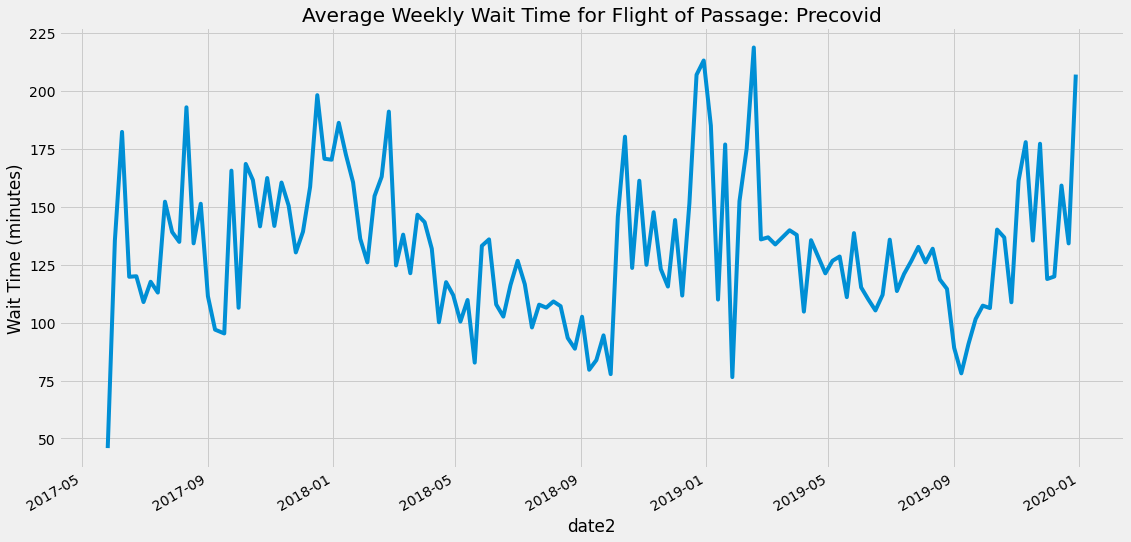

In [25]:
plt.figure(figsize = (17, 9))
plt.title("Average Weekly Wait Time for Flight of Passage: Precovid")
plt.xlabel('Week Number')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

precovid_weekly['avg_weekly_wait'].plot();

This ride opened May 27, 2017.

There is definite weekly fluctuation, but it doesn't appear to form a clear pattern.  The major spikes at December, 2017, 2018, and 2019 are due to higher park attendance at Christmas.  There are also spikes in February of those years (a common week off for schoolchildren) and possibly for spring breaks.  I expect that kind of seasonality will be difficult to identify having only a few years of data and so many spikes.

# Modeling

## Null Model

In [26]:
# Overall average wait time before covid
precovid['SPOSTMIN'].mean()

133.68505728447226

The overall average wait time for this ride before covid was almost 134 minutes (2 hours and 14 min).  

Advice: Buy Genie Plus and reserve a time to ride this ride.

##  Weekly ACF and PACF Plots

In [27]:
precovid_weekly.shape

(136, 8)

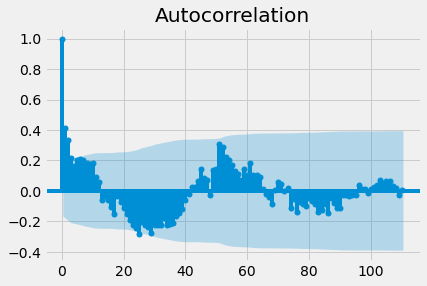

In [28]:
# Weekly ACF plot for May 26, 2017 - Dec 31, 2019: pre-covid
plot_acf(precovid_weekly['avg_weekly_wait'], lags=110)
plt.show()

The cosine wave-like nature of this autocorrelation plot indicates seasonality, or at least lack of stationarity.  The partial autocorrelation plots will tell more.

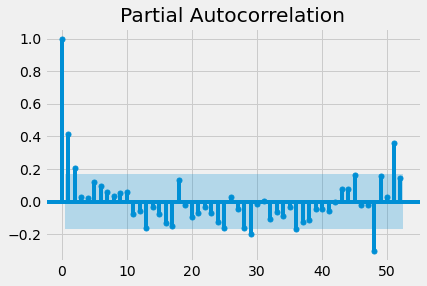

In [29]:
# Weekly PACF plot for May 26, 2017 - Dec 31, 2019: pre-covid
plot_pacf(precovid_weekly['avg_weekly_wait'], lags=52)
plt.show()

The most partial autocorrelation is at the beginning and the end of the timeframe.  The most negative partial autocorrelation, which indicates a lot of variation, hovers around the summer and what I suspect is the week after Thanksgiving.

### 90 Day ACF and PACF Plots

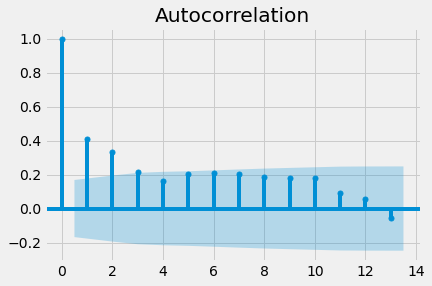

In [30]:
# 13 Week plot beginning May 26, 2017 (roughly 3 months)
plot_acf(precovid_weekly['avg_weekly_wait'], lags=13)
plt.show()

# The x-axis is in weeks

There's definite autocorrelation for the first 3 weeks, and slight autocorrelation at weeks 5-8.

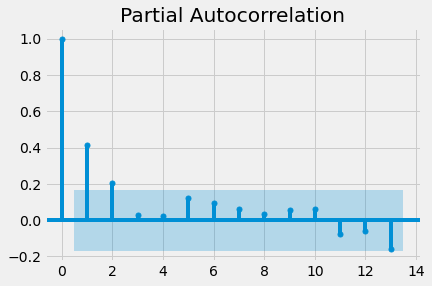

In [31]:
# 13 Week plot beginning May 26, 2017 (roughly 3 months)
plot_pacf(precovid_weekly['avg_weekly_wait'], lags=13)
plt.show()

# The x-axis is in weeks

This 3 month plot indicates that seasonality exists.  There are drops when flexible travelers can save a lot of time in lines.  The key is to seize those intervals.  Since Easter, Passover, Memorial Day, and Thanksgiving are all on different dates each year, mathematical predictions become more complex.  I'd prefer to model the data based on the week number, but ARIMA models require using a datetime field.

In [34]:
precovid_weekly_3 = precovid_weekly.copy()
precovid_weekly_3['datetime'].dt.date

# RESAMPLE SO SARIMAX WILL WORK (ride closures caused some irregularities)
precovid_weekly_3.resample('D').interpolate()[::7]

# from https://stackoverflow.com/questions/14530556/resample-time-series-in-pandas-to-a-weekly-interval

ValueError: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got linear

In [33]:
from datetime import date, timedelta


#Start date and end_date
start_date = pd.to_datetime("2017-05-26")
#end_date = pd.to_datetime("2019-01-01") - timedelta(days=1)

#List of all dates
precovid_weekly_3['all_dates'] = pd.date_range(start_date, 136, freq='w')



#fillna(129.4, inplace=True)

NameError: name 'precovid_weekly_3' is not defined

In [ ]:
model = pmd.auto_arima(precovid_weekly_3['avg_weekly_wait'], m=52, trace=True)

In [ ]:
sarimax_model = sm.tsa.statespace.SARIMAX(precovid_weekly_3['avg_weekly_wait'], order=(1,0,1), seasonal_order=(0,0,1, 52))
flight_results = sarimax_model.fit()

In [ ]:
print(f'Mean absolute error: {flight_results.mae}')
print(f'Mean squared error: {flight_results.mse}')

Unlike for the other rides, the error scores for this one are higher.  I'm not very surprised, since the AIC scores all exceeded 5,000.  Still based on the adfuller test below, the data are stationary.  This tells me that there's so much variation (causing the error) that the data are stationary because fluctuations cannot be predicted.

In [ ]:
# print summary of fit model
print(flight_results.summary())

In [ ]:
# To eliminate any doubt, here's an adfuller test:
adfuller(precovid_weekly_3['avg_weekly_wait'])

Given an alpha of .05 and a p-value of .0000546, the data are stationary.

# Pickle

In [ ]:
with open('models/flight_results.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(flight_results, pickle_out)

## Predict Wait Times

In [ ]:
covid_weekly_3 = covid_weekly[['avg_weekly_wait', 'date2']]
covid_weekly_3.set_index('date2', inplace=True)

In [ ]:
covid_weekly_3

In [ ]:
# Predictions
start_index = 0
end_index = len(covid_weekly_3)
forecast = flight_results.predict(start=start_index, end=end_index)

In [ ]:
forecast